**Kütüphaneler yüklendi**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import cudf
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import accuracy_score
from cuml.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from cuml.svm import SVC
from cuml.metrics import accuracy_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

**Veri seti url üzerinden okundu**

In [ ]:

# Veri setini yükleme
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"

# Sütun isimlerini belirleme (veri seti dokümantasyonundan alınmıştır)
column_names = [
    'label',
    'lepton_pT',
    'lepton_eta',
    'lepton_phi',
    'missing_energy_magnitude',
    'missing_energy_phi',
    'jet_1_pt',
    'jet_1_eta',
    'jet_1_phi',
    'jet_1_b-tag',
    'jet_2_pt',
    'jet_2_eta',
    'jet_2_phi',
    'jet_2_b-tag',
    'jet_3_pt',
    'jet_3_eta',
    'jet_3_phi',
    'jet_3_b-tag',
    'jet_4_pt',
    'jet_4_eta',
    'jet_4_phi',
    'jet_4_b-tag',
    'm_jj',
    'm_jjj',
    'm_lv',
    'm_jlv',
    'm_bb',
    'm_wbb',
    'm_wwbb'
]


try:

    df = pd.read_csv(url, compression='gzip', header=None, names=column_names)
except MemoryError:
    # Bellek hatası alırsak, daha küçük bir örnekle başla
    df = pd.read_csv(url, compression='gzip', header=None, names=column_names, nrows=500000)


**Ratgele 100 bin örneklem seçilerek dataFraame oluşturuldu. Temel istatistiklere bakıldı. Eksik değer kontrolü yapıldı.**

In [ ]:
sample_size = 100000
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df.copy()
    print(f"Uyarı: Veri seti yalnızca {len(df)} satır içeriyor, tüm veri seti kullanıldı.")

# Veriyi inceleme
print(f"Toplam örnek sayısı: {len(df_sample)}")
print("\nİlk 5 satır:")
display(df_sample.head())

print("\nTemel istatistikler:")
display(df_sample.describe())

print("\nEksik değer kontrolü:")
display(df_sample.isnull().sum())

Toplam örnek sayısı: 100000

İlk 5 satır:


,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,...,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
3967303,0.0,1.138683,-0.726635,-0.005790,0.204118,0.153842,1.585904,-0.045576,-1.448527,1.086538,...,-2.439800,0.073642,0.000000,1.790497,1.730592,0.980587,0.743065,2.378752,1.534863,1.227558
5946179,1.0,0.404633,1.014821,-1.050041,1.136441,-1.403536,3.218436,-1.944837,0.801788,0.000000,...,-1.174742,-0.912542,0.000000,1.072789,0.649697,0.981147,2.004577,0.521853,1.246037,1.461494
6910558,0.0,1.137585,0.325251,1.453598,0.804114,0.893516,0.418095,-1.164536,-0.585919,0.000000,...,0.280201,-0.982461,3.101961,0.816500,0.933867,0.988956,0.852772,0.415455,0.737194,0.691437
3414332,0.0,1.380438,-0.595149,-0.727112,0.465392,-0.057453,0.399224,-0.076273,1.080084,2.173076,...,1.261267,1.129085,0.000000,0.563342,0.857068,0.992465,0.875139,0.512037,0.686362,0.887047
5840458,1.0,0.962628,1.191110,-1.161568,1.541759,0.569159,1.337374,0.810973,0.458075,1.086538,...,0.413452,1.309431,3.101961,1.596246,1.146864,1.687726,1.178736,0.925320,1.094308,0.991339



Temel istatistikler:


,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,...,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.528070,0.992554,-0.000602,-0.004260,0.999137,-0.002249,0.990098,-0.002727,0.006184,0.998137,...,0.001027,-0.001307,0.998568,1.033667,1.025067,1.050058,1.011071,0.972753,1.033415,0.959866
std,0.499214,0.568334,1.008224,1.006271,0.601586,1.005826,0.476736,1.008985,1.006383,1.027471,...,1.008073,1.003940,1.400065,0.672248,0.378881,0.164294,0.399550,0.525784,0.365025,0.311864
min,0.000000,0.274697,-2.434976,-1.742508,0.003814,-1.743905,0.145381,-2.968735,-1.741237,0.000000,...,-2.497265,-1.742691,0.000000,0.102053,0.234663,0.295962,0.339518,0.059529,0.353780,0.388232
25%,0.000000,0.588923,-0.741244,-0.878589,0.576816,-0.872066,0.677161,-0.689225,-0.862137,0.000000,...,-0.712525,-0.868704,0.000000,0.789445,0.846455,0.985744,0.768995,0.672989,0.819720,0.771336
50%,1.000000,0.853737,-0.000054,-0.005790,0.891782,-0.003008,0.893170,-0.002006,0.015129,1.086538,...,0.002871,-0.003594,0.000000,0.893912,0.950657,0.989826,0.917474,0.873202,0.948311,0.872382
75%,1.000000,1.241717,0.739188,0.866555,1.293416,0.866857,1.169916,0.684223,0.876074,2.173076,...,0.713269,0.866611,3.101961,1.024143,1.085807,1.020552,1.145310,1.137996,1.141776,1.059431
max,1.000000,8.749847,2.432920,1.743236,9.632102,1.743196,6.844616,2.967694,1.741454,2.173076,...,2.498009,1.743372,3.101961,21.860922,10.939556,5.559782,10.567759,10.452003,7.070516,5.289892



Eksik değer kontrolü:


,0
label,0
lepton_pT,0
lepton_eta,0
lepton_phi,0
missing_energy_magnitude,0
missing_energy_phi,0
jet_1_pt,0
jet_1_eta,0
jet_1_phi,0
jet_1_b-tag,0


**Aykırı değerlerin hesaplanması yapılmıştır. Burada IQR yöntemi kullanıldı. Box plot grafiği ile görsel olarak incelenmiştir. Ve Aykırı değer sahip veriler sınır değerleriyle değiştirilmiştir. Ek olarak aykırı değer düzeltme öncesi ve sonrası karşılaştırılması yapılmıştır.**

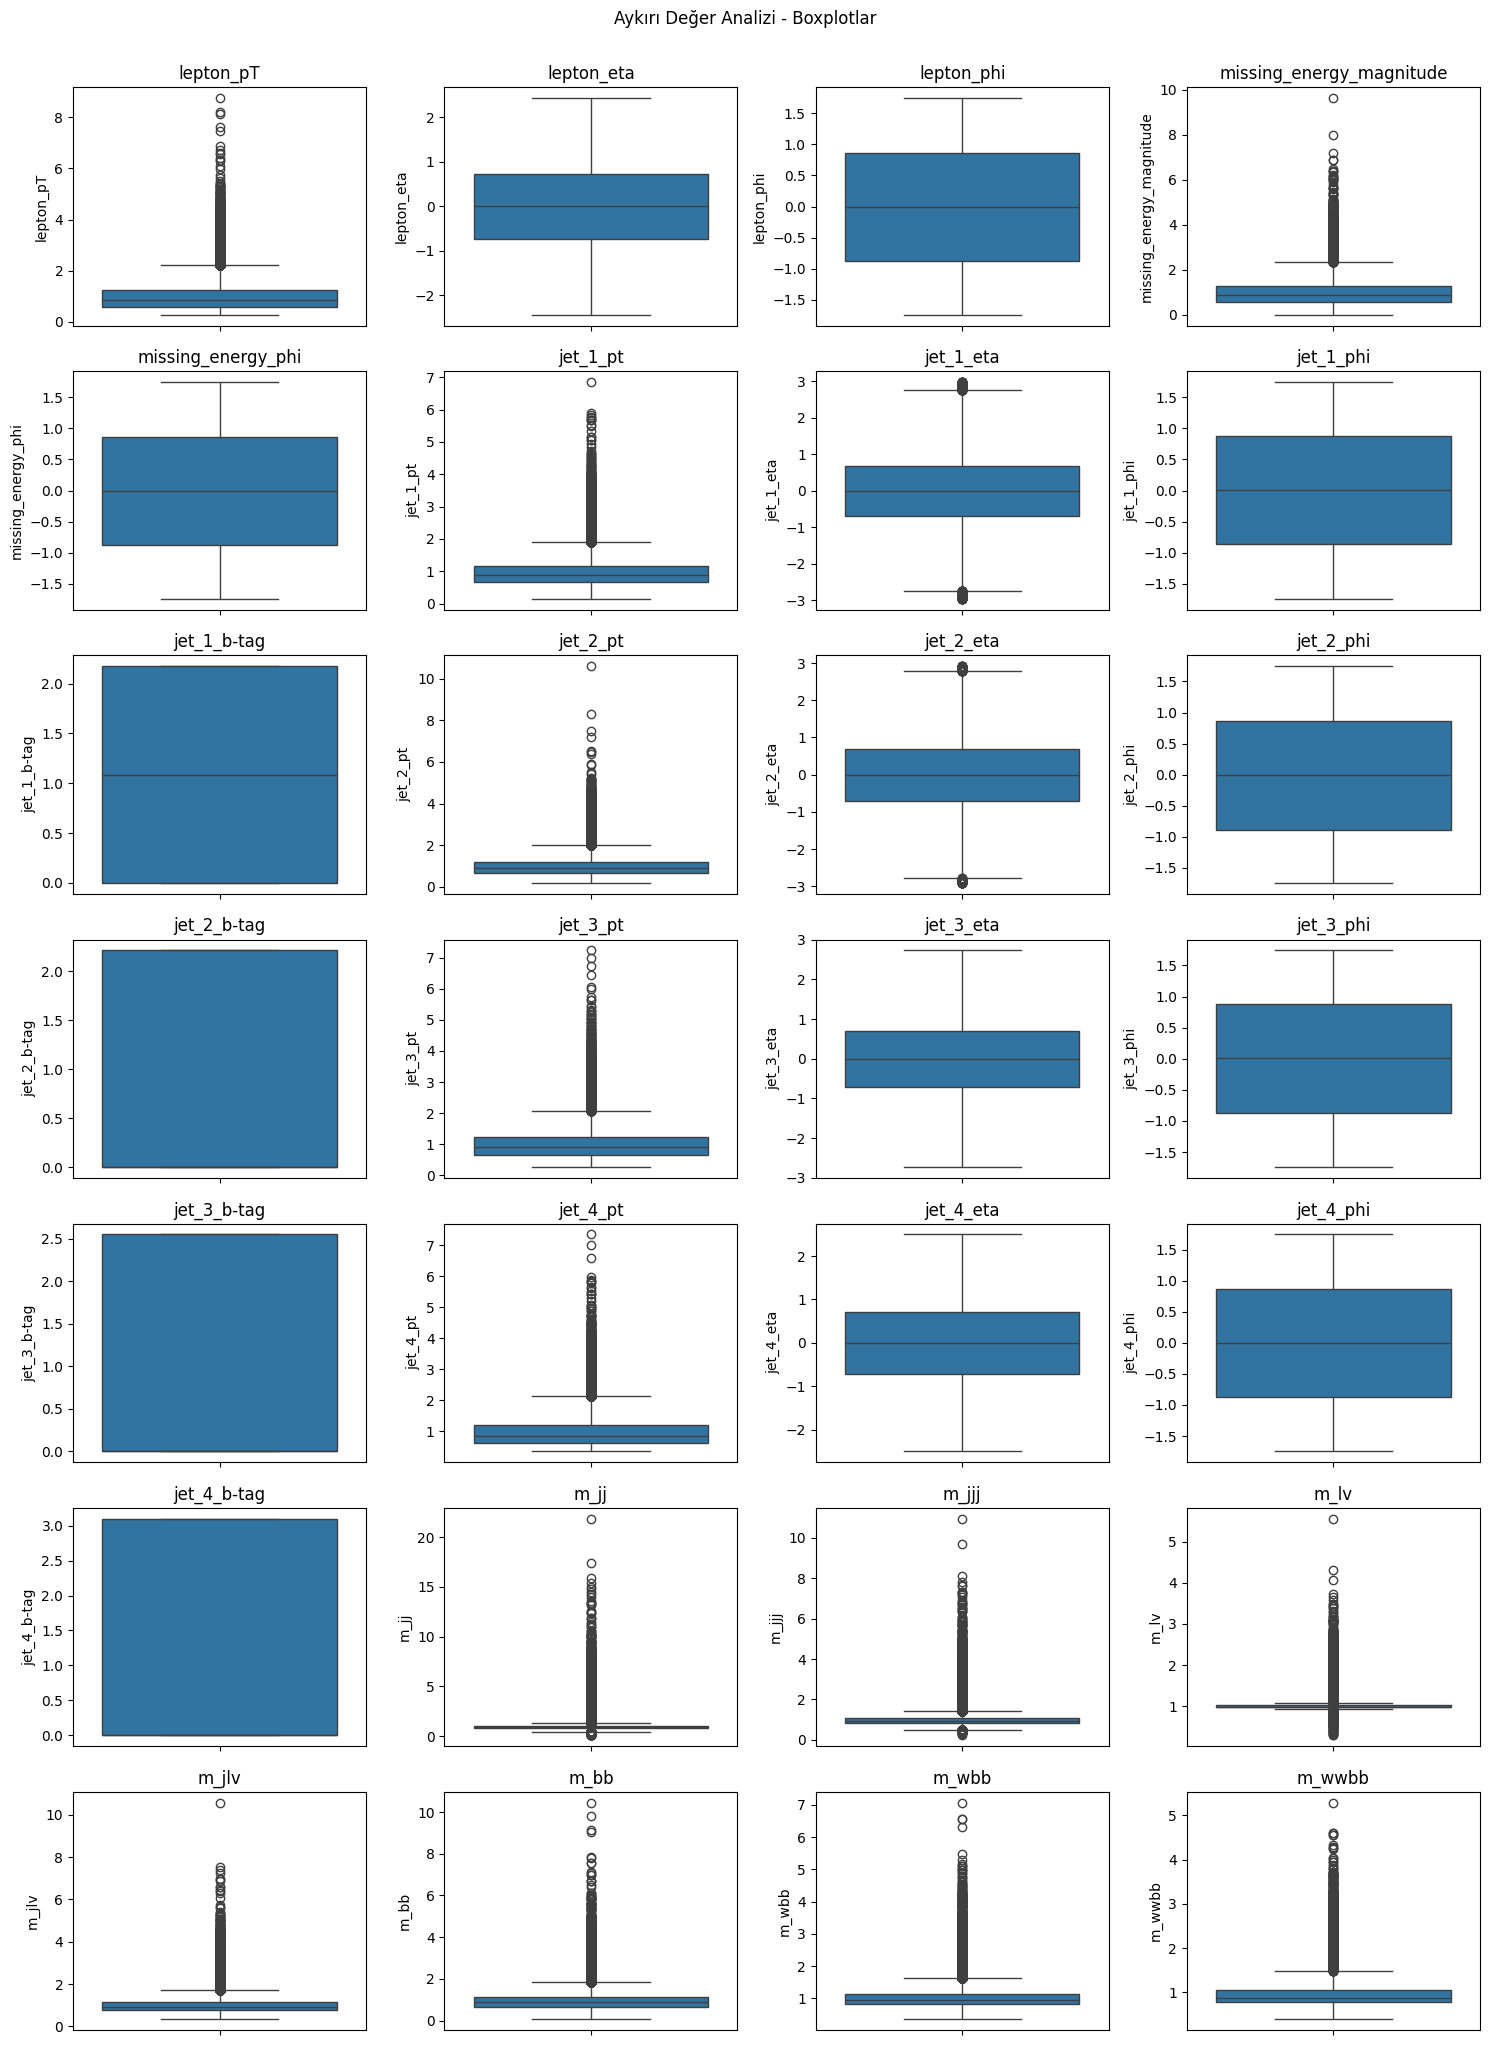

lepton_pT sütunu için:
- Alt sınır: -0.3903, Üst sınır: 2.2209
- Tespit edilen aykırı değer sayısı: 3815 (3.82%)
- Aykırı değerler alt/üst sınırlara çekildi
lepton_eta sütunu için:
- Alt sınır: -2.9619, Üst sınır: 2.9598
- Tespit edilen aykırı değer sayısı: 0 (0.00%)
- Aykırı değerler alt/üst sınırlara çekildi
lepton_phi sütunu için:
- Alt sınır: -3.4963, Üst sınır: 3.4843
- Tespit edilen aykırı değer sayısı: 0 (0.00%)
- Aykırı değerler alt/üst sınırlara çekildi
missing_energy_magnitude sütunu için:
- Alt sınır: -0.4981, Üst sınır: 2.3683
- Tespit edilen aykırı değer sayısı: 2989 (2.99%)
- Aykırı değerler alt/üst sınırlara çekildi
missing_energy_phi sütunu için:
- Alt sınır: -3.4804, Üst sınır: 3.4752
- Tespit edilen aykırı değer sayısı: 0 (0.00%)
- Aykırı değerler alt/üst sınırlara çekildi
jet_1_pt sütunu için:
- Alt sınır: -0.0620, Üst sınır: 1.9090
- Tespit edilen aykırı değer sayısı: 4991 (4.99%)
- Aykırı değerler alt/üst sınırlara çekildi
jet_1_eta sütunu için:
- Alt sınır: -2.749

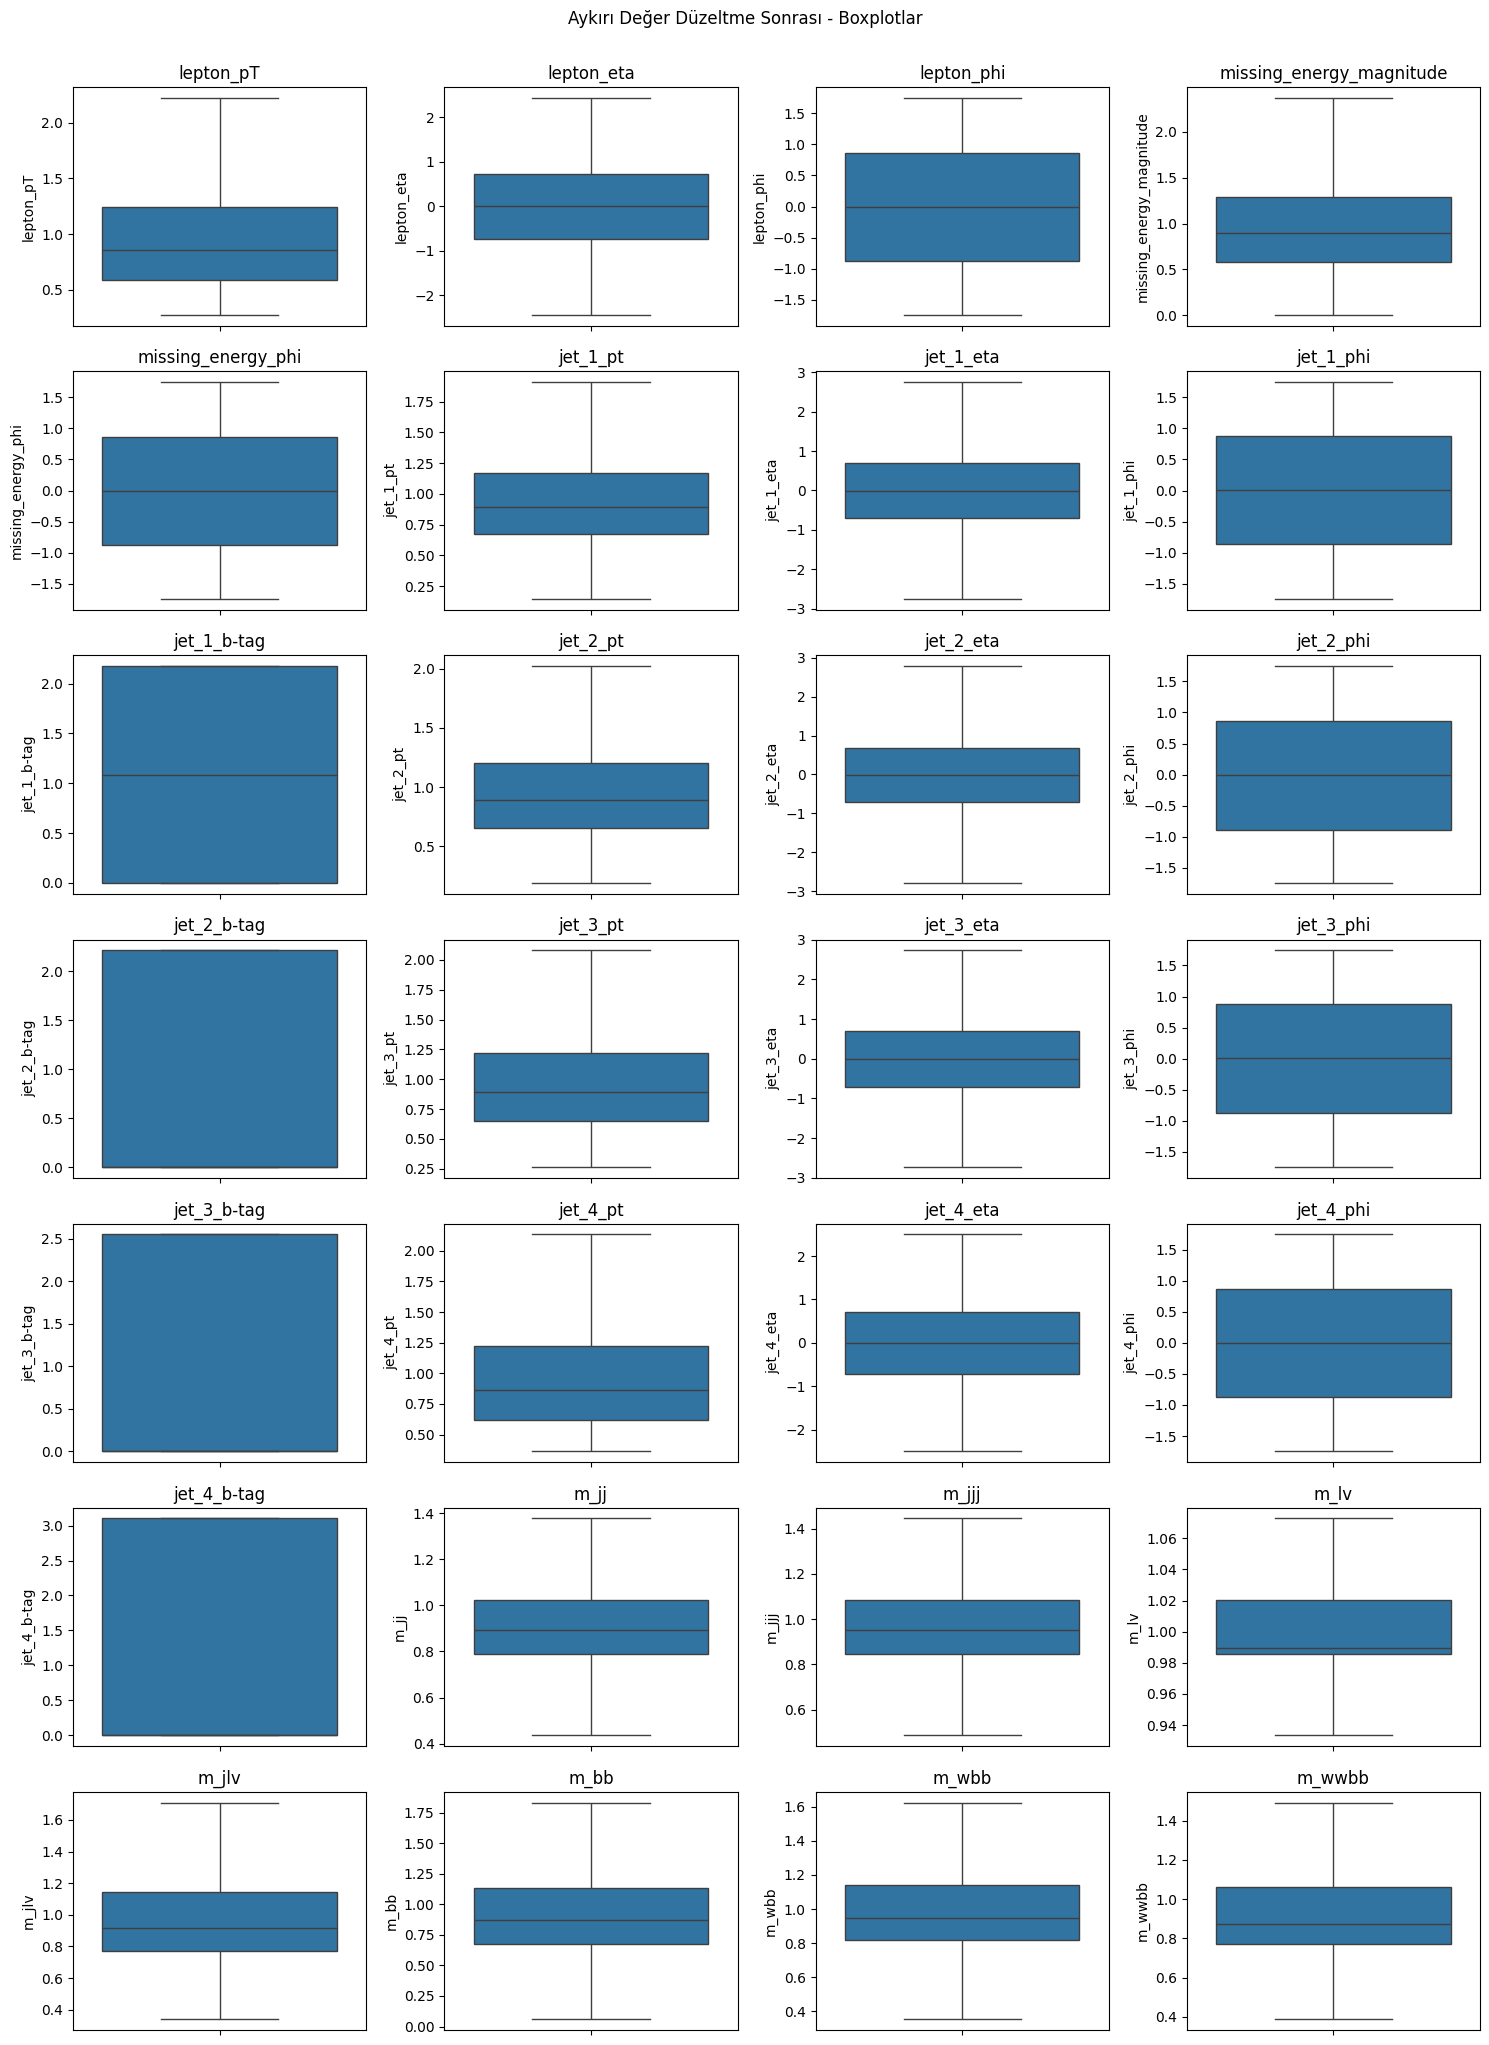


Aykırı Değer Özeti:
lepton_pT: 3815 aykırı değer
lepton_eta: 0 aykırı değer
lepton_phi: 0 aykırı değer
missing_energy_magnitude: 2989 aykırı değer
missing_energy_phi: 0 aykırı değer
jet_1_pt: 4991 aykırı değer
jet_1_eta: 686 aykırı değer
jet_1_phi: 0 aykırı değer
jet_1_b-tag: 0 aykırı değer
jet_2_pt: 3967 aykırı değer
jet_2_eta: 407 aykırı değer
jet_2_phi: 0 aykırı değer
jet_2_b-tag: 0 aykırı değer
jet_3_pt: 3204 aykırı değer
jet_3_eta: 0 aykırı değer
jet_3_phi: 0 aykırı değer
jet_3_b-tag: 0 aykırı değer
jet_4_pt: 3257 aykırı değer
jet_4_eta: 0 aykırı değer
jet_4_phi: 0 aykırı değer
jet_4_b-tag: 0 aykırı değer
m_jj: 13987 aykırı değer
m_jjj: 7357 aykırı değer
m_lv: 19811 aykırı değer
m_jlv: 5037 aykırı değer
m_bb: 6004 aykırı değer
m_wbb: 6194 aykırı değer
m_wwbb: 5933 aykırı değer

İşlem Öncesi ve Sonrası Temel İstatistikler Karşılaştırması:

lepton_pT sütunu:
İşlem öncesi:


,lepton_pT
count,100000.000000
mean,0.972537
std,0.499264
min,0.274697
25%,0.588923
50%,0.853737
75%,1.241717
max,2.220907



lepton_eta sütunu:
İşlem öncesi:


,lepton_eta
count,100000.000000
mean,-0.000602
std,1.008224
min,-2.434976
25%,-0.741244
50%,-0.000054
75%,0.739188
max,2.432920



lepton_phi sütunu:
İşlem öncesi:


,lepton_phi
count,100000.000000
mean,-0.004260
std,1.006271
min,-1.742508
25%,-0.878589
50%,-0.005790
75%,0.866555
max,1.743236



missing_energy_magnitude sütunu:
İşlem öncesi:


,missing_energy_magnitude
count,100000.000000
mean,0.982102
std,0.542112
min,0.003814
25%,0.576816
50%,0.891782
75%,1.293416
max,2.368315


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# IQR fonksiyonu
def detect_and_handle_outliers(df, column, threshold=1.5, method='clip'):
    """
    IQR yöntemi ile aykırı değerleri tespit eder ve belirtilen methoda göre işlem yapar

    Parameters:
        df: DataFrame
        column: İşlem yapılacak sütun adı
        threshold: IQR çarpanı (default 1.5)
        method: 'clip' (sınırlara çekme), 'remove' (silme), 'none' (sadece tespit)

    Returns:
        İşlenmiş DataFrame ve aykırı değer sayısı
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    n_outliers = len(outliers)

    print(f"{column} sütunu için:")
    print(f"- Alt sınır: {lower_bound:.4f}, Üst sınır: {upper_bound:.4f}")
    print(f"- Tespit edilen aykırı değer sayısı: {n_outliers} ({n_outliers/len(df)*100:.2f}%)")

    if method == 'clip':
        df[column] = df[column].clip(lower_bound, upper_bound)
        print("- Aykırı değerler alt/üst sınırlara çekildi")
    elif method == 'remove':
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        print("- Aykırı değerler silindi")
    else:
        print("- Aykırı değerler işlenmedi (sadece tespit)")

    return df, n_outliers

# Sayısal sütunları seçme (label hariç)
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.drop('label')

# Aykırı değer analizi ve işleme
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(7, 4, i)
    sns.boxplot(y=df_sample[col])
    plt.title(col)
    plt.tight_layout()
plt.suptitle('Aykırı Değer Analizi - Boxplotlar', y=1.02)
plt.show()

# Her sütun için IQR uygulama
outliers_report = {}
for col in numeric_cols:
    df_sample, n_outliers = detect_and_handle_outliers(df_sample, col, method='clip')
    outliers_report[col] = n_outliers

# İşlem sonrası boxplotlar
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(7, 4, i)
    sns.boxplot(y=df_sample[col])
    plt.title(col)
    plt.tight_layout()
plt.suptitle('Aykırı Değer Düzeltme Sonrası - Boxplotlar', y=1.02)
plt.show()

# Aykırı değer raporu
print("\nAykırı Değer Özeti:")
for col, count in outliers_report.items():
    print(f"{col}: {count} aykırı değer")

# İstatistiklerin karşılaştırılması
print("\nİşlem Öncesi ve Sonrası Temel İstatistikler Karşılaştırması:")
for col in numeric_cols[:4]:  # İlk 4 sütun için örnek gösterim
    print(f"\n{col} sütunu:")
    print("İşlem öncesi:")
    display(df_sample[col].describe())

**X değişkenleri (bağımsız değişken) ve y (bağımlı değişken) olarak ayrıldı.**

In [ ]:
X = df_sample.drop('label', axis=1)
y = df_sample['label']
y = pd.DataFrame(y, columns=["label"]).reset_index(drop=True)

**MinMax Scalar ile X değişkenleri 0,1 aralığında dönüştürüldü.**

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df = pd.concat([X_scaled_df, y], axis=1)


**Dönüştürülen veriler bir önceki kodlarda X ile y birleştirilmişti tekrar X ve y ayırma işlemi yapıldı.**

In [ ]:
X_t = scaled_df.drop('label', axis=1)
y_t = scaled_df['label']

**Mutual Information yöntemi ile en iyi 15 öznitelik seçildi**

In [ ]:
# Mutual Information ile en iyi 15 özelliği seç
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_yeni = selector.fit_transform(X_t, y_t)
ozellik_isimleri = X_t.columns
# Seçilen özellik isimlerini ve skorlarını al
skorlar = pd.DataFrame(selector.scores_)
sutunlar = pd.DataFrame(ozellik_isimleri)

# Özet DataFrame oluştur
ozellik_skorlari = pd.concat([sutunlar, skorlar], axis=1)
ozellik_skorlari.columns = ['Özellik', 'Mutual_Info_Skoru']

# Skora göre sırala ve ilk 15'i seç
en_iyi_15_ozellik = ozellik_skorlari.sort_values(by='Mutual_Info_Skoru', ascending=False).head(15)
print(en_iyi_15_ozellik)

                     Özellik  Mutual_Info_Skoru
25                      m_bb           0.051052
27                    m_wwbb           0.021114
26                     m_wbb           0.020296
22                     m_jjj           0.017008
24                     m_jlv           0.011057
3   missing_energy_magnitude           0.006824
20               jet_4_b-tag           0.006238
12               jet_2_b-tag           0.005089
8                jet_1_b-tag           0.004383
6                  jet_1_eta           0.003761
5                   jet_1_pt           0.003106
0                  lepton_pT           0.002893
7                  jet_1_phi           0.001995
18                 jet_4_eta           0.001538
21                      m_jj           0.001354


**Seçilen 15 öznitelik ayrı bir dataframe e atandı**

In [ ]:
X_t_selected=X_t[en_iyi_15_ozellik["Özellik"]]

**Modellerin kurulumu yapıldı. Çeşitli parametreler tanımlandı.**

*   KNN
*   SVM
*   MLP
*   XGBoost


In [ ]:
# Modeller ve hiperparametre aralıkları
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3,4,5,6,7,8,9,10,11]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1,10],
            'kernel': ['linear','rbf']
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu', 'tanh']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6]
        }
    }
}


**Dış Döngü ve İç döngü ile beraber modeller çalıştırıldı. Dış döngü 5 iç döngü 3 olarak ayarlandı. En iyi dış döngüye göre ROC eğrileri ve ROC-AUC skorları hesaplandı. Aynı şekilde performans metriklerii hesaplandı.**


KNN modeli için nested CV çalıştırılıyor...


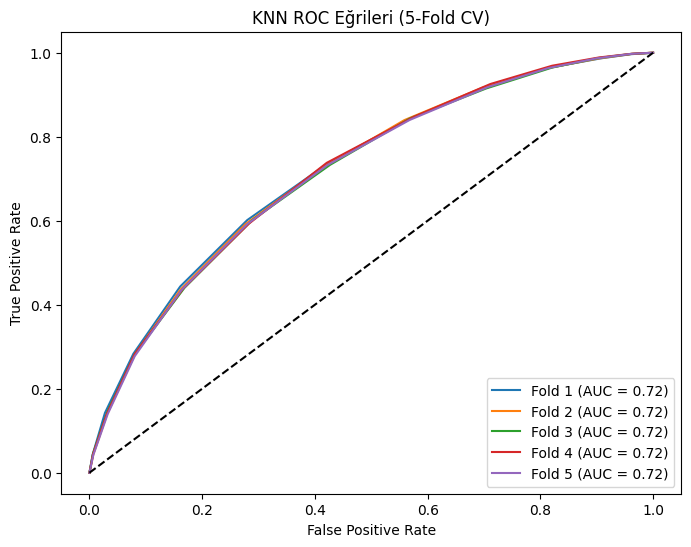


KNN Model Sonuçları:
- Ortalama Accuracy: 0.6603
- Ortalama Precision: 0.6609
- Ortalama Recall: 0.7326
- Ortalama F1: 0.6949
- Ortalama ROC-AUC: 0.7189
- En iyi parametre kombinasyonları:
  Fold 1: {'n_neighbors': 11}
  Fold 2: {'n_neighbors': 11}
  Fold 3: {'n_neighbors': 11}
  Fold 4: {'n_neighbors': 11}
  Fold 5: {'n_neighbors': 11}

SVM modeli için nested CV çalıştırılıyor...


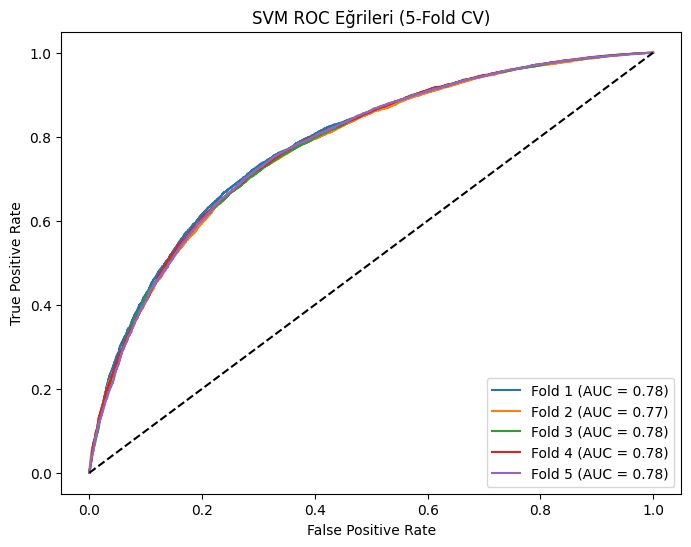


SVM Model Sonuçları:
- Ortalama Accuracy: 0.7104
- Ortalama Precision: 0.7088
- Ortalama Recall: 0.7663
- Ortalama F1: 0.7364
- Ortalama ROC-AUC: 0.7779
- En iyi parametre kombinasyonları:
  Fold 1: {'C': 10, 'kernel': 'rbf'}
  Fold 2: {'C': 10, 'kernel': 'rbf'}
  Fold 3: {'C': 10, 'kernel': 'rbf'}
  Fold 4: {'C': 10, 'kernel': 'rbf'}
  Fold 5: {'C': 10, 'kernel': 'rbf'}

MLP modeli için nested CV çalıştırılıyor...


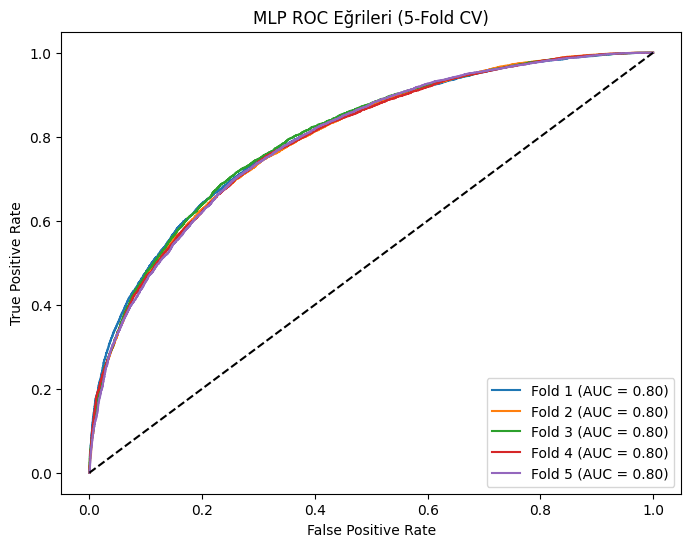


MLP Model Sonuçları:
- Ortalama Accuracy: 0.7185
- Ortalama Precision: 0.7231
- Ortalama Recall: 0.7618
- Ortalama F1: 0.7405
- Ortalama ROC-AUC: 0.7981
- En iyi parametre kombinasyonları:
  Fold 1: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
  Fold 2: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
  Fold 3: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
  Fold 4: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
  Fold 5: {'activation': 'relu', 'hidden_layer_sizes': (100,)}

XGBoost modeli için nested CV çalıştırılıyor...


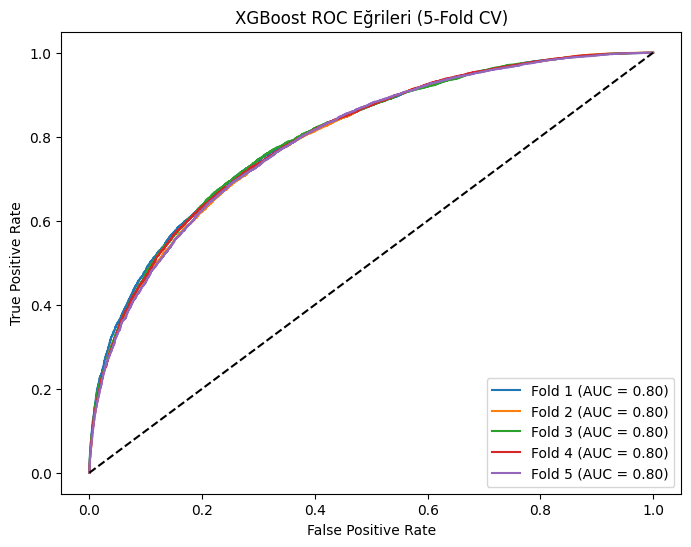


XGBoost Model Sonuçları:
- Ortalama Accuracy: 0.7202
- Ortalama Precision: 0.7311
- Ortalama Recall: 0.7437
- Ortalama F1: 0.7373
- Ortalama ROC-AUC: 0.7987
- En iyi parametre kombinasyonları:
  Fold 1: {'max_depth': 6, 'n_estimators': 50}
  Fold 2: {'max_depth': 6, 'n_estimators': 50}
  Fold 3: {'max_depth': 6, 'n_estimators': 50}
  Fold 4: {'max_depth': 6, 'n_estimators': 50}
  Fold 5: {'max_depth': 6, 'n_estimators': 50}


In [ ]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Performans metriklerini saklamak için
results = {}

# Nested CV
for model_name, model_info in models.items():
    print(f"\n{model_name} modeli için nested CV çalıştırılıyor...")

    model = model_info['model']
    param_grid = model_info['params']

    # Metrikleri saklamak için
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'best_params': []
    }

    # ROC eğrileri için
    plt.figure(figsize=(8, 6))

    # Outer loop
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_t_selected, y_t)):
        X_train, X_test = X_t_selected.iloc[train_idx], X_t_selected.iloc[test_idx]
        y_train, y_test = y_t[train_idx], y_t[test_idx]

        # Inner loop (hiperparametre optimizasyonu)
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                  scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # En iyi modelle tahmin yapma
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)

        # Metrikleri hesaplama
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['f1'].append(f1_score(y_test, y_pred))
        metrics['roc_auc'].append(roc_auc_score(y_test, y_proba[:, 1]))
        metrics['best_params'].append(grid_search.best_params_)

        # ROC eğrisi çizme
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {metrics["roc_auc"][-1]:.2f})')

    # ROC eğrisini formatlama
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Eğrileri (5-Fold CV)')
    plt.legend(loc='lower right')
    plt.show()

    # Sonuçları kaydetme
    results[model_name] = metrics

    # Model sonuçlarını yazdırma
    print(f"\n{model_name} Model Sonuçları:")
    print(f"- Ortalama Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"- Ortalama Precision: {np.mean(metrics['precision']):.4f}")
    print(f"- Ortalama Recall: {np.mean(metrics['recall']):.4f}")
    print(f"- Ortalama F1: {np.mean(metrics['f1']):.4f}")
    print(f"- Ortalama ROC-AUC: {np.mean(metrics['roc_auc']):.4f}")
    print("- En iyi parametre kombinasyonları:")
    for i, params in enumerate(metrics['best_params'], 1):
        print(f"  Fold {i}: {params}")

**YORUMLAR**

Bu çalışmada, HIGGS veri seti üzerinde bir makine öğrenmesi projesi gerçekleştirilmiş, veri ön işleme, özellik seçimi, modelleme ve değerlendirme adımları uygulanmıştır.

Veri setindeki aykırı değerler, IQR (Interquartile Range) yöntemiyle tespit edilmiş ve sınır değerlerle baskılanmıştır. Aykırı değerlerin etkisi azaltılarak modelin daha sağlıklı öğrenmesi sağlanmıştır.

Tüm sayısal özellikler, MinMaxScaler ile [0, 1] aralığına ölçeklendirilmiştir. Farklı ölçeklerdeki değişkenlerin model performansını olumsuz etkilemesi engellenmiştir.

Mutual Information kullanılarak en iyi 15 özellik seçilmiştir. Gereksiz özelliklerin elenmesiyle model karmaşıklığı azaltılmış ve eğitim süresi optimize edilmiştir.

Nested Cross-Validation Yaklaşımı
Dış Çapraz Doğrulama (Outer CV): 5-fold

İç Çapraz Doğrulama (Inner CV): 3-fold

Hiperparametre Optimizasyonu: İç döngüde GridSearchCV ile en iyi parametreler belirlenmiştir.

Test Edilen Modeller ve Performansları
Model    |   ROC-AUC |   Accuracy |
|:---------|----------|-----------:|
| KNN   |  0.7189        | 0.6603
| SVM |  0.7779 |  0.7104
| MLP    |  0.7981 |  0.7185
| XGBoost     |  0.7987 |  0.7202


**Model karşılaştırmalarına göre en iyi accuracy ve roc-auc değere sahip olan XGBoost modelimizi seçip kullanabiliriz.**